<a href="https://colab.research.google.com/github/matheeshapathirana/Netflix-cookie-checker/blob/colab-version/Netflix_Cookie_Checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Use Netflix-cookie-checker

---



In this Colab notebook, we will see how to set up and run Netflix-cookie-checker on Linux in order to validate cookies.

## Join [Discord Server](https://discord.gg/RSCdKeKB5X) for support!

---



## a) Upload cookies
# 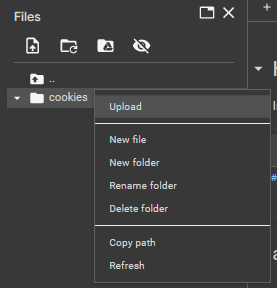

### Upload your cookies to the cookies folder



# b) Install requirements

In [ ]:
# Install the required packages
!pip install Requests
!pip install bs4
!pip install beautifulsoup4
!pip install psutil
!pip install aiohttp

# c) Convert Netscape cookies to json format

In [ ]:
import json
import os
import random
import shutil
import progressbar


try:
    if os.name == "posix":
        folder_path = "cookies"

    else:
        while True:
            import tkinter
            from tkinter import filedialog

            print("\n<<< Select Netscape cookies folder >>>\n\n")
            tkinter.Tk().withdraw()
            folder_path = filedialog.askdirectory()
            if folder_path == "":
                print("Trying to use default folder 'cookies'\n")
                folder_path = "cookies"
                break

            else:
                break

    def maximum():
        count = 0
        for files in os.walk(folder_path):
            count += len(files)
            return count

    rand_number = random.randint(1, 99999)

    progress = 0
    pbar = progressbar.ProgressBar(maxval=maximum())

    def convert_netscape_cookie_to_json(cookie_file_content):
        cookies = []
        for line in cookie_file_content.splitlines():
            fields = line.strip().split("\t")
            if len(fields) >= 7:
                cookie = {
                    "domain": fields[0].replace("www", ""),
                    "flag": fields[1],
                    "path": fields[2],
                    "secure": fields[3] == "TRUE",
                    "expiration": fields[4],
                    "name": fields[5],
                    "value": fields[6],
                }
                cookies.append(cookie)

        json_content = json.dumps(cookies, indent=4)
        return json_content

    path = "json_cookies"
    try:
        os.mkdir(path)
        print(f"Folder {path} created!\n")
        try:
            for filename in os.listdir(folder_path):
                filepath = os.path.join(folder_path, filename)
                if os.path.isfile(filepath):
                    with open(filepath, "r", encoding="utf-8") as file:
                        content = file.read()

                    json_data = convert_netscape_cookie_to_json(content)

                    with open(f"json_cookies/{filename}", "w", encoding="utf-8") as f:
                        f.write(json_data)
                        print(f"{filename} - DONE!")
                        if 0 <= progress <= maximum():
                            pbar.start()
                            pbar.update(progress)
                            progress += 1
                        else:
                            pass
        except FileNotFoundError:
            print(
                "Error Occurred :Default 'cookies' folder not found, please select a valid folder"
            )
            os.rmdir(path)

    except FileExistsError:
        if (
            input(
                "Do you want to remove old cookies folder? (y/n)\n [y] Recommended \n > : "
            )
            == "y"
        ):
            shutil.rmtree(path)
            os.mkdir(path)
            for filename in os.listdir(folder_path):
                filepath = os.path.join(folder_path, filename)
                if os.path.isfile(filepath):
                    with open(filepath, "r", encoding="utf-8") as file:
                        content = file.read()

                    json_data = convert_netscape_cookie_to_json(content)

                    with open(f"json_cookies/{filename}", "w", encoding="utf-8") as f:
                        f.write(json_data)
                        print(f"{filename} - DONE!")
                        if 0 <= progress <= maximum():
                            pbar.start()
                            pbar.update(progress)
                            progress += 1
                        else:
                            pass

        else:
            os.mkdir(str(f"temp {rand_number}"))
            for filename in os.listdir(folder_path):
                filepath = os.path.join(folder_path, filename)
                if os.path.isfile(filepath):
                    with open(filepath, "r") as file:
                        content = file.read()

                    json_data = convert_netscape_cookie_to_json(content)

                    with open(
                        f"temp {rand_number}/{filename}", "w", encoding="utf-8"
                    ) as f:
                        f.write(json_data)
                        print(f"{filename} - DONE!")
                        if 0 <= progress <= maximum():
                            pbar.start()
                            pbar.update(progress)
                            progress += 1
                        else:
                            pass

            print(f"\n\nsaved cookies to the temp folder - temp {rand_number}")
    pbar.finish()

except KeyboardInterrupt:
    print("\n\nProgram Interrupted by user")
    exit()


# d) Start Checker

In [ ]:
import json
import os
import sys
import asyncio
import time
import aiohttp

print("Initializing!, Please wait...\n")
working_cookies_path = "working_cookies"
exceptions = 0
working_cookies = 0
expired_cookies = 0
start = time.time()

num_threads = 20  # Define the number of threads here


# ___________________________________________
# | Network Speed | Recommended no. threads |
# |---------------|-------------------------|
# | < 5 Mbps      | 1-3                     |
# | 5-20 Mbps     | 3-5                     |
# | 20-100 Mbps   | 5-10                    |
# | > 100 Mbps    | 10-20                   |
# |_________________________________________|


async def load_cookies_from_json(json_cookies_path):
    with open(json_cookies_path, "r", encoding="utf-8") as cookie_file:
        cookie = json.load(cookie_file)
    return cookie


async def open_webpage_with_cookies(session, link, json_cookies, filename):
    global working_cookies
    global expired_cookies

    # Request the page
    await session.get(link)

    # Clear all existing cookies
    session.cookie_jar.clear()

    for cookie in json_cookies:
        session.cookie_jar.update_cookies({cookie["name"]: cookie["value"]})

    async with session.get(link, timeout=10) as response:
        content = await response.text()
        if "Sign In" in content or "Sign in" in content:
            print(f"Cookie Not working - {filename}")
            expired_cookies += 1
        else:
            plan = "Premium" if "<b>Premium</b>" in content else "Basic" if "<b>Basic</b>" in content else "Standard" if "<b>Standard</b>" in content else "Unknown"
            print(f"Cookie Working - {filename} | Plan: {plan}")
            try:
                os.mkdir(working_cookies_path)
                working_cookies += 1
                return content  # Return content if the cookie is working
            except FileExistsError:
                working_cookies += 1
                return content  # Return content if the cookie is working


async def process_cookie_file(filename):
    filepath = os.path.join("json_cookies", filename)
    if os.path.isfile(filepath):
        with open(filepath, "r", encoding="utf-8"):
            url = "https://www.netflix.com/YourAccount"
            try:
                cookies = await load_cookies_from_json(filepath)
                async with aiohttp.ClientSession() as session:
                    content = await open_webpage_with_cookies(
                        session, url, cookies, filename
                    )
                    if content:
                        # Save working cookies to JSON file
                        with open(f"working_cookies/{filename}.json", "w") as json_file:
                            json.dump(cookies, json_file)
            except json.decoder.JSONDecodeError:
                print(
                    f"Please use cookie_converter.py to convert your cookies to json format! (File: {filename})\n"
                )
                global exceptions
                exceptions += 1
            except Exception as e:
                print(f"Error occurred: {str(e)} - {filename}\n")
                exceptions += 1


async def main():
    tasks = []
    for filename in os.listdir("json_cookies"):
        task = asyncio.create_task(process_cookie_file(filename))
        tasks.append(task)
        if len(tasks) >= num_threads:
            await asyncio.gather(*tasks)
            tasks = []
    if tasks:
        await asyncio.gather(*tasks)


try:
    await(main())
    end = time.time()
    print(
        f"\nSummary:\nTotal cookies: {len(os.listdir('json_cookies'))}\nWorking cookies: {working_cookies}\nExpired cookies: {expired_cookies}\nInvalid cookies: {exceptions}\nTime Elapsed: {end - start} Seconds"
    )
except KeyboardInterrupt:
    print("\n\nProgram Interrupted by user")
    sys.exit()
